<a href="https://colab.research.google.com/github/senguptashritama/Multilabel-Classification-of-ResearchPapers/blob/main/LSTM_BILSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Loading required libraries and preprocessed dataset -

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Dense, Embedding, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/archive (4)/filtered_data.csv")
df.head()

,titles,summaries,terms
0,survey semantic stereo match semantic depth ...,stereo match one widely use technique infer de...,"['cs.CV', 'cs.LG']"
1,futureai guide principle consensus recommend...,recent advancement artificial intelligence a...,"['cs.CV', 'cs.AI', 'cs.LG']"
2,enforce mutual consistency hard region semisup...,paper propose novel mutual consistency netwo...,"['cs.CV', 'cs.AI']"
3,parameter decoupling strategy semisupervise 3d...,consistency training prove advanced semisuperv...,['cs.CV']
4,backgroundforeground segmentation interior sen...,ensure safety automate drive correct percept...,"['cs.CV', 'cs.LG']"


### Encoding target variable using MultilabelBinarizer

In [ ]:
df['terms'] = df['terms'].str.replace("'", "")

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer


terms_split = df['terms'].str.strip('][').str.split(', ')
mlb = MultiLabelBinarizer()
y_encoded = pd.DataFrame(mlb.fit_transform(terms_split), columns=mlb.classes_)

print(mlb.classes_)

['cs.AI' 'cs.CV' 'cs.LG' 'eess.IV' 'stat.ML']


In [ ]:
combined_data = pd.concat([df, y_encoded], axis=1)

In [ ]:
combined_data.head()

,titles,summaries,terms,cs.AI,cs.CV,cs.LG,eess.IV,stat.ML
0,survey semantic stereo match semantic depth ...,stereo match one widely use technique infer de...,"[cs.CV, cs.LG]",0,1,1,0,0
1,futureai guide principle consensus recommend...,recent advancement artificial intelligence a...,"[cs.CV, cs.AI, cs.LG]",1,1,1,0,0
2,enforce mutual consistency hard region semisup...,paper propose novel mutual consistency netwo...,"[cs.CV, cs.AI]",1,1,0,0,0
3,parameter decoupling strategy semisupervise 3d...,consistency training prove advanced semisuperv...,[cs.CV],0,1,0,0,0
4,backgroundforeground segmentation interior sen...,ensure safety automate drive correct percept...,"[cs.CV, cs.LG]",0,1,1,0,0


In [ ]:
combined_data.drop(columns=["terms"],inplace=True)

In [ ]:
combined_data.head()

,titles,summaries,cs.AI,cs.CV,cs.LG,eess.IV,stat.ML
0,survey semantic stereo match semantic depth ...,stereo match one widely use technique infer de...,0,1,1,0,0
1,futureai guide principle consensus recommend...,recent advancement artificial intelligence a...,1,1,1,0,0
2,enforce mutual consistency hard region semisup...,paper propose novel mutual consistency netwo...,1,1,0,0,0
3,parameter decoupling strategy semisupervise 3d...,consistency training prove advanced semisuperv...,0,1,0,0,0
4,backgroundforeground segmentation interior sen...,ensure safety automate drive correct percept...,0,1,1,0,0


### Tokenizing and Padding the "titles" and "summaries"

In [ ]:
X = combined_data[['titles', 'summaries']]
y = combined_data[['cs.AI', 'cs.CV', 'cs.LG', 'eess.IV', 'stat.ML']]

# Tokenize text data
max_words = 1000
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X['titles'] + ' ' + X['summaries'])

In [ ]:
X_seq = tokenizer.texts_to_sequences(X['titles'] + ' ' + X['summaries'])
max_len = max(len(x) for x in X_seq)

# Pad sequences
X_pad = pad_sequences(X_seq, maxlen=max_len)

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pad, y.values, test_size=0.2, random_state=42)

### Calculating costs based on class frequencies

In [ ]:
class_frequencies = y_train.mean(axis=0)
label_costs = 1 / class_frequencies
sample_weights = np.array([label_costs[label] for label in np.argmax(y_train, axis=1)])

### LSTM Model Training

The model architecture comprises an embedding layer followed by multiple LSTM layers with dropout regularization to prevent overfitting. Finally, a dense output layer with sigmoid activation is added for the classification task.

In [ ]:
# Set a random state for reproducibility
random_state = 42

In [ ]:
# Define LSTM model
np.random.seed(random_state)
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout to the first LSTM layer
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout to the second LSTM layer
model.add(LSTM(units=32))
model.add(Dense(5, activation='sigmoid'))

The model is compiled using binary cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric, both for training and validation. Additionally, it includes weighted accuracy as a metric, to handle class imbalance. The model is trained for 20 epochs on the training data with a batch size of 64, utilizing a portion (20%) of the data for validation, and employing callbacks for model checkpointing and early stopping based on validation loss.

In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=['accuracy'])

Epoch 1/20
283/283 [==============================] - ETA: 0s - loss: 0.9813 - accuracy: 0.7507 - weighted_accuracy: 0.5157
Epoch 1: val_loss improved from inf to 0.91083, saving model to best_model.keras
283/283 [==============================] - 78s 273ms/step - loss: 0.9813 - accuracy: 0.7507 - weighted_accuracy: 0.5157 - val_loss: 0.9108 - val_accuracy: 0.7707 - val_weighted_accuracy: 0.5309
Epoch 2/20
283/283 [==============================] - ETA: 0s - loss: 0.9278 - accuracy: 0.7666 - weighted_accuracy: 0.5255
Epoch 2: val_loss improved from 0.91083 to 0.90578, saving model to best_model.keras
283/283 [==============================] - 71s 253ms/step - loss: 0.9278 - accuracy: 0.7666 - weighted_accuracy: 0.5255 - val_loss: 0.9058 - val_accuracy: 0.7745 - val_weighted_accuracy: 0.5326
Epoch 3/20
283/283 [==============================] - ETA: 0s - loss: 0.9567 - accuracy: 0.7345 - weighted_accuracy: 0.5066
Epoch 3: val_loss did not improve from 0.90578
283/283 [==================

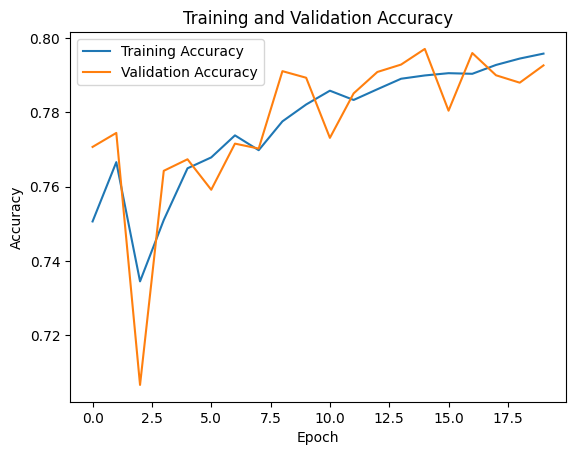

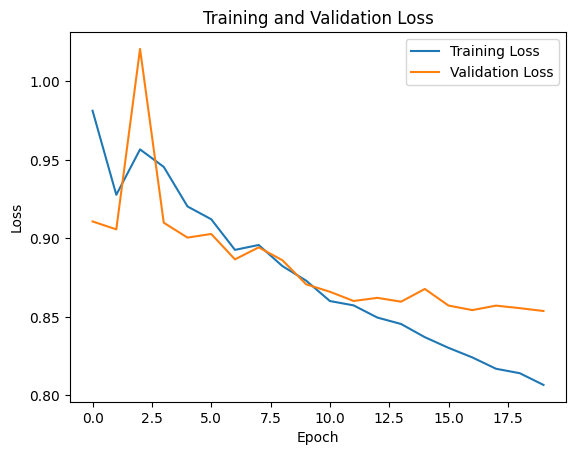

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights=True, mode='min', verbose=1)

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, sample_weight=sample_weights,
                    callbacks=[checkpoint, early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Evaluate model
# Evaluate model
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]

print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')


177/177 [==============================] - 8s 43ms/step - loss: 0.3343 - accuracy: 0.7855 - weighted_accuracy: 0.7855
Test Loss: 0.3342844247817993, Test Accuracy: 0.78553706407547


In [ ]:
import numpy as np

# Predict on test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = np.round(y_pred_prob)

# Decode predicted labels
mlb = MultiLabelBinarizer(classes=['cs.AI', 'cs.CV', 'cs.LG', 'eess.IV', 'stat.ML'])
mlb.fit(y.columns)

y_pred_labels = mlb.inverse_transform(y_pred)

# Print predicted classes for each sample
for i, labels in enumerate(y_pred_labels):
    print(f"Sample {i + 1}: Predicted Classes - {labels}")


Streaming output truncated to the last 5000 lines.
Sample 643: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 644: Predicted Classes - ('cs.CV',)
Sample 645: Predicted Classes - ('cs.CV', 'cs.LG')
Sample 646: Predicted Classes - ('cs.CV',)
Sample 647: Predicted Classes - ('cs.CV', 'cs.LG')
Sample 648: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 649: Predicted Classes - ('cs.CV',)
Sample 650: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 651: Predicted Classes - ('cs.LG', 'stat.ML')
Sample 652: Predicted Classes - ('cs.CV',)
Sample 653: Predicted Classes - ('cs.CV',)
Sample 654: Predicted Classes - ('cs.CV',)
Sample 655: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 656: Predicted Classes - ('cs.CV',)
Sample 657: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 658: Predicted Classes - ('cs.CV',)
Sample 659: Predicted Classes - ('cs.CV',)
Sample 660: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 661: Predicted Classes - ('c

The model is successfully able to classify a paper in more than 2 labels.

177/177 [==============================] - 7s 39ms/step


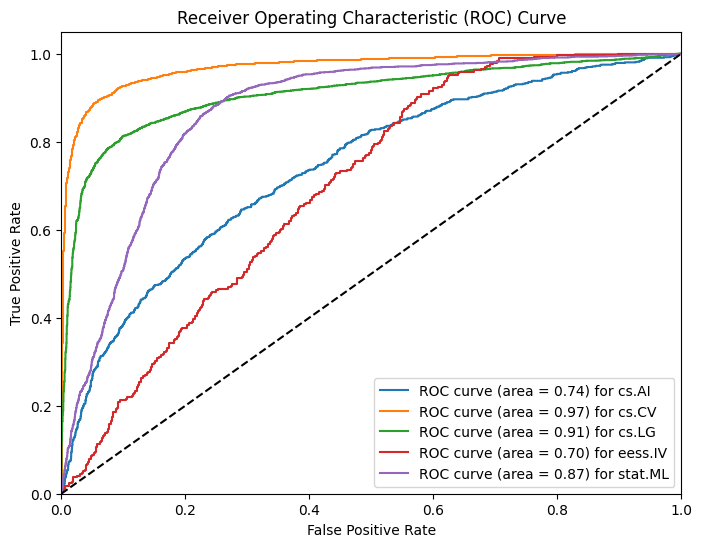

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict on test data
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for {mlb.classes_[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


### "eess.IV" and "cs.AI" are better classified by LSTM compared to the ML models.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

# Compute weighted averages
weighted_precision = (precision * support).sum() / support.sum()
weighted_recall = (recall * support).sum() / support.sum()
weighted_f1_score = (f1_score * support).sum() / support.sum()

# Print the results
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-score:", weighted_f1_score)

Weighted Precision: 0.7921786716251326
Weighted Recall: 0.7820019778046369
Weighted F1-score: 0.7853632027864449


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Overall score is also much improved.

### Bi-LSTM model training

In [ ]:
# Set a random state for reproducibility
random_state = 42

In [ ]:
from keras.layers import Bidirectional

# Define bidirectional LSTM model
np.random.seed(random_state)
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=64, input_length=max_len))
model.add(Bidirectional(LSTM(units=32, return_sequences=True)))
model.add(Dropout(0.2))  # Add dropout to the first bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=16, return_sequences=True)))
model.add(Dropout(0.2))  # Add dropout to the second bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=8)))
model.add(Dense(5, activation='sigmoid'))


In [ ]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'],weighted_metrics=['accuracy'])

In [ ]:
# Define callbacks
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=2,restore_best_weights=True, mode='min', verbose=1)

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, sample_weight=sample_weights,
                    callbacks=[checkpoint, early_stopping])


Epoch 1/20
283/283 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.6472 - weighted_accuracy: 0.4509
Epoch 1: val_loss improved from inf to 0.94754, saving model to best_model.keras
283/283 [==============================] - 100s 316ms/step - loss: 1.1481 - accuracy: 0.6472 - weighted_accuracy: 0.4509 - val_loss: 0.9475 - val_accuracy: 0.7842 - val_weighted_accuracy: 0.5360
Epoch 2/20
283/283 [==============================] - ETA: 0s - loss: 0.9232 - accuracy: 0.7722 - weighted_accuracy: 0.5293
Epoch 2: val_loss improved from 0.94754 to 0.91321, saving model to best_model.keras
283/283 [==============================] - 87s 309ms/step - loss: 0.9232 - accuracy: 0.7722 - weighted_accuracy: 0.5293 - val_loss: 0.9132 - val_accuracy: 0.7419 - val_weighted_accuracy: 0.5143
Epoch 3/20
283/283 [==============================] - ETA: 0s - loss: 0.8923 - accuracy: 0.7829 - weighted_accuracy: 0.5364
Epoch 3: val_loss improved from 0.91321 to 0.89150, saving model to best_

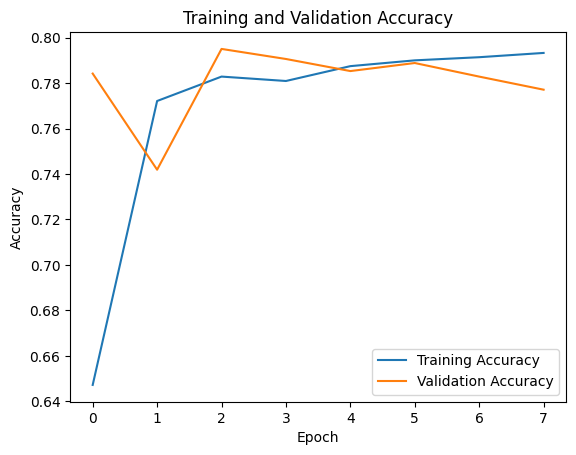

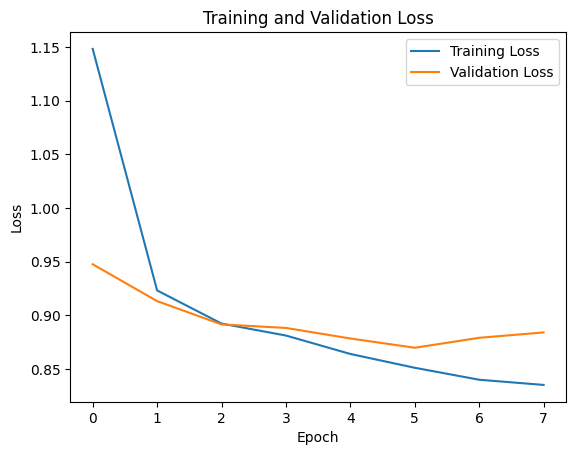

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate model
# Evaluate model
results = model.evaluate(X_test, y_test)
loss = results[0]
accuracy = results[1]

print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

177/177 [==============================] - 21s 99ms/step - loss: 0.3346 - accuracy: 0.7868 - weighted_accuracy: 0.7868
Test Loss: 0.33455079793930054, Test Accuracy: 0.7867777347564697


In [ ]:
import numpy as np

# Predict on test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = np.round(y_pred_prob)

# Decode predicted labels
mlb = MultiLabelBinarizer(classes=['cs.AI', 'cs.CV', 'cs.LG', 'eess.IV', 'stat.ML'])
mlb.fit(y.columns)

y_pred_labels = mlb.inverse_transform(y_pred)

# Print predicted classes for each sample
for i, labels in enumerate(y_pred_labels):
    print(f"Sample {i + 1}: Predicted Classes - {labels}")

Streaming output truncated to the last 5000 lines.
Sample 643: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 644: Predicted Classes - ('cs.CV',)
Sample 645: Predicted Classes - ('cs.CV',)
Sample 646: Predicted Classes - ('cs.CV',)
Sample 647: Predicted Classes - ('cs.CV',)
Sample 648: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 649: Predicted Classes - ('cs.CV',)
Sample 650: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 651: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 652: Predicted Classes - ('cs.CV',)
Sample 653: Predicted Classes - ('cs.CV',)
Sample 654: Predicted Classes - ('cs.LG',)
Sample 655: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 656: Predicted Classes - ('cs.CV',)
Sample 657: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 658: Predicted Classes - ('cs.CV',)
Sample 659: Predicted Classes - ('cs.CV',)
Sample 660: Predicted Classes - ('cs.AI', 'cs.LG', 'stat.ML')
Sample 661: Predicted Classes - ('cs.AI', 

177/177 [==============================] - 9s 50ms/step


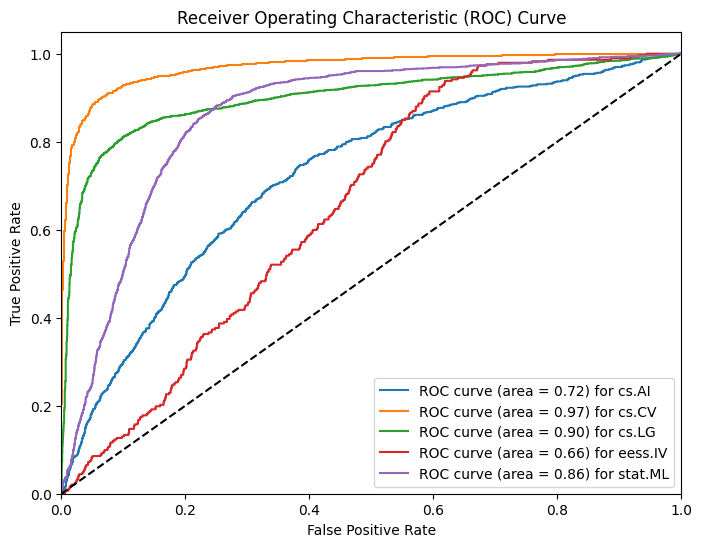

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict on test data
y_pred_prob = model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(mlb.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(len(mlb.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:0.2f}) for {mlb.classes_[i]}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred)

# Compute weighted averages
weighted_precision = (precision * support).sum() / support.sum()
weighted_recall = (recall * support).sum() / support.sum()
weighted_f1_score = (f1_score * support).sum() / support.sum()

# Print the results
print("Weighted Precision:", weighted_precision)
print("Weighted Recall:", weighted_recall)
print("Weighted F1-score:", weighted_f1_score)

Weighted Precision: 0.7866538668631486
Weighted Recall: 0.7949675859795627
Weighted F1-score: 0.7854989913634839


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### BI-LSTM works almost same as LSTM with performance slightly degraded.